# Exemplo 13: Reconhecimento de Imagens e Augmentação usando Tensorflow e Keras

## Exemplo reconhecimento de espécies de flores

Um dos problemas clássicos de Aprendizado Profundo (Deep Learning) usando Redes Neurais Convolucionais (CNNs) é a identificação de flores. A partir de uma base com 4500 imagens JPEG de 5 espécies de flores com cores, tamanhos e ângulos diferentes podemos identificar a qual espécie uma foto de flor qualquer pode ser classificada.   

Este exemplo mostra uma forma usual de organização de classificação de imagens. As imagens já classificadas são colocadas em diretórios diferentes com o nome da espécie. O programa inicialmente lê um diretório de imagens, cria um vetor de features e inclui um tag de identificação igual ao nome do diretório. Cada diretório pode comnter qualquer numero de imagens, no entanto, é obrigatório que cada diretório possua apenas uma categoria de imagem.

Aumento de dados (em inglês, augmentation) é uma técnica usada para expandir ou ampliar o conjunto de dados para treinamento do modelo usando variações dos dados existentes. Para isso, aplicamos diferentes técnicas para expandir nosso conjunto de dados de modo que ajude a treinar melhor nosso modelo com um conjunto de dados maior. O aumento de imagem (image augmentation) é uma das técnicas que podemos aplicar em um conjunto de dados de imagem para expandir nosso conjunto de dados de forma que reduza o overfitting em nosso modelo. As técnicas mais comuns são deslocar a imagem, espelhar horizontal e verticalmente, aplicar zoom e variar contraste. Essa técnica deve ser usada com cuidado, pois seu uso pode piorar a acurácia além de aumentar o tempo de processamento.

A base de dados é separada em base de treinamento e base de validação (teste). A rede é treinada com a base de treinamento e a base de validação avalia a acurácia de cada modelo utilizado e o tempo de treinamento é medido.

O primeiro modelo é o simples, com poucas camadas. O segundo é o modelo complexo com 18 camadas. Depois usaremos redes pré-treinadas. A técnica chamada aprendizagem de transferência, onde uma rede pré-treinada (treinada com cerca de um milhão de imagens genericas), é usada para extrair atributos e treinar uma nova camada no topo para classificar as imagens de flores.

No final é apresentado uma tabela comparando a acurácia e tempo de processamento do treinamento de cada modelo.

In [1]:
# Load libs
import tensorflow as tf
from tensorflow.keras import layers, models, utils
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import IPython.display as display
import numpy as np
import matplotlib.pyplot as plt
import os, pathlib
from time import perf_counter

AUTOTUNE = tf.data.experimental.AUTOTUNE

print("TF version:", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.4.1
GPU is NOT AVAILABLE


## Define hyperparameters

In [2]:
# Set hyperparameters
VAL_SAMPLE = 0.2
BATCH_SIZE = 50
SHUFFLE_BUFFER = 1000
IMG_HEIGHT = 224
IMG_WIDTH = 224
EPOCHS=5

# Set main images directory
data_repo = "/data/dataset/flower_photos/"

# Set base directory (where are all flower's directories)
data_dir = pathlib.Path(data_repo)
print(data_dir)

/data/dataset/flower_photos


## Bibliotecas úteis

In [3]:
# Print some flowers
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(20):
        ax = plt.subplot(5,5,n+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image_batch[n])
        plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')
    plt.show()

## Leitura images do repositorio

In [4]:
# Estrutura dos diretorios
#
# data_repo / dandelion  / image_x.jpg ... 
#           / daisy      / image_x.jpg ...
#           / sunflower  / image_x.jpg ...
#           / rose       / image_x.jpg ...
#           / tulip      / image_x.jpg ...

# Count the number of flower images and set dataset size
SIZE_OF_DATASET = len(list(data_dir.glob('*/*.jpg')))

print("Number of images: ",SIZE_OF_DATASET)

Number of images:  4510


In [5]:
# Get the Class names reading directory names
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
print(CLASS_NAMES)

['dandelion' 'daisy' 'sunflower' 'rose' 'tulip']


## Image Processing and Augmentation

In [6]:
#Set start time for prepare images
start_time = perf_counter()

# Configuring Image generator to execute image augmentation in training data
train_datagen = ImageDataGenerator(
    validation_split=VAL_SAMPLE,    # Split validation data
    rescale=1./255,                  # scale images from integers 0-255 to floats 0-1.
#    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=20,
#    width_shift_range=0.2,
#    height_shift_range=0.2,
#    horizontal_flip=True 
)

# Configuring Image generator to rescale image in validation data (they dont need augmentation)
val_datagen = ImageDataGenerator(
    validation_split=VAL_SAMPLE,  # Split validation data
    rescale=1./255,                # scale images from integers 0-255 to floats 0-1.
)

In [7]:
# Create augmented training dataset reading images from directory
train_ds = train_datagen.flow_from_directory(
    data_dir,                            # directory name in format class/images.jpg
    class_mode='categorical',            # classe type
    color_mode='rgb',                    # 'grayscale', 'rgb', 'rgba' 
    subset="training",                   # define train dataset
    seed=123,
    target_size=(IMG_HEIGHT, IMG_WIDTH), # output image size
    classes = list(CLASS_NAMES),         # list of classes names
    shuffle=True,                        # Set shuffle
    batch_size=BATCH_SIZE                # Batch size
)

Found 3609 images belonging to 5 classes.


In [8]:
# Create validation dataset reading images from directory
val_ds = val_datagen.flow_from_directory(
    data_dir,                            # directory name in format class/images.jpg
    class_mode='categorical',            # classe type
    color_mode='rgb',                    # 'grayscale', 'rgb', 'rgba' 
    subset="validation",                 # define validation dataset
    seed=123,
    target_size=(IMG_HEIGHT, IMG_WIDTH), # output image size
    classes = list(CLASS_NAMES),         # list of classes names
    shuffle=True,                        # Set shuffle
    batch_size=BATCH_SIZE                # Batch size
)

Found 901 images belonging to 5 classes.


In [9]:
# Calculate train and validation step
STEP_SIZE_TRAIN=train_ds.n//train_ds.batch_size
STEP_SIZE_VALID=val_ds.n//val_ds.batch_size

In [10]:
time_ip = perf_counter() - start_time
tf.print("Image processing time: ", time_ip, "s")

Image processing time:  0.6816283810185269 s


(50, 224, 224, 3) (50, 5)


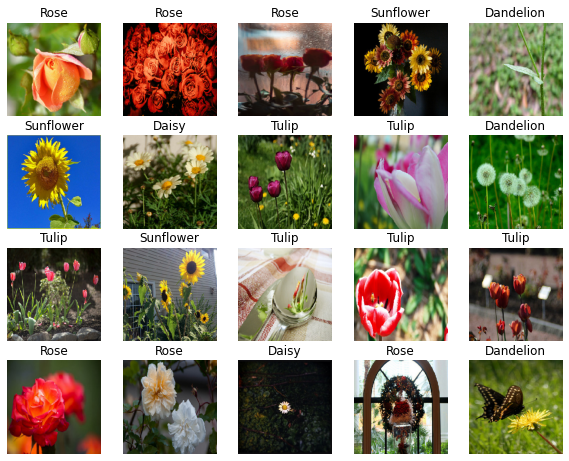

In [11]:
# Print some images with label
images, labels = next(val_ds)
print(images.shape, labels.shape)
show_batch(images, labels)

# Create Convolutional Neural Network (CNN) Model

## Simple Model

In [12]:
start_time = perf_counter()

model = models.Sequential([
    layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(5, activation='relu'),
    layers.Dense(5)
], name = 'Simple_Model')

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "Simple_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 50176)            

In [13]:
history = model.fit(train_ds, validation_data=val_ds, validation_steps=STEP_SIZE_VALID,
                    batch_size=BATCH_SIZE, epochs=EPOCHS, steps_per_epoch=STEP_SIZE_TRAIN)

Epoch 1/5
72/72 [==============================] - 75s 1s/step - loss: 1.6087 - accuracy: 0.2222 - val_loss: 1.6061 - val_accuracy: 0.2356
Epoch 2/5
72/72 [==============================] - 72s 997ms/step - loss: 1.6058 - accuracy: 0.2318 - val_loss: 1.6043 - val_accuracy: 0.2344
Epoch 3/5
72/72 [==============================] - 72s 999ms/step - loss: 1.6039 - accuracy: 0.2363 - val_loss: 1.6029 - val_accuracy: 0.2356
Epoch 4/5
72/72 [==============================] - 72s 995ms/step - loss: 1.6016 - accuracy: 0.2319 - val_loss: 1.6020 - val_accuracy: 0.2356
Epoch 5/5
72/72 [==============================] - 72s 993ms/step - loss: 1.6009 - accuracy: 0.2394 - val_loss: 1.6016 - val_accuracy: 0.2356


### Evaluating the Simple CNN Model Performance

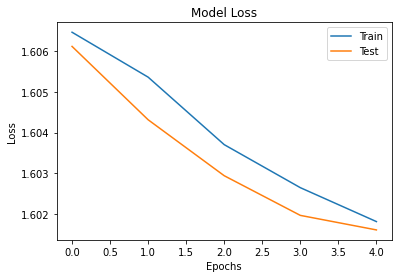

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

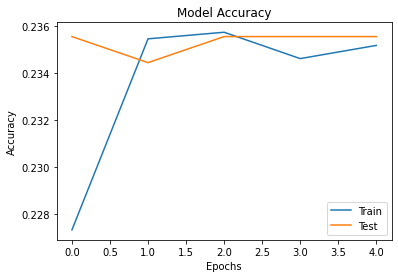

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

In [16]:
train_loss_sm, train_acc_sm = model.evaluate(train_ds, batch_size=BATCH_SIZE)
test_loss_sm, test_acc_sm = model.evaluate(val_ds, batch_size=BATCH_SIZE)
time_sm = perf_counter() - start_time
print(time_sm)

19/19 [==============================] - 6s 340ms/step - loss: 1.6015 - accuracy: 0.2353
429.91573257395066


## Complex Model 

In [17]:
start_time = perf_counter()

model = models.Sequential([
# layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3), name='conv_1'),
    layers.Conv2D(32, (3,3), activation='relu', name='conv_2'),
    layers.MaxPooling2D(pool_size=(2,2), name='maxpool_1'),
    layers.Dropout(0.25),
    layers.Conv2D(64, (3,3), padding='same', activation='relu', name='conv_3'),
    layers.Conv2D(64, (3,3), activation='relu', name='conv_4'),
    layers.MaxPooling2D(pool_size=(2,2), name='maxpool_2'),
    layers.Dropout(0.25),
    layers.Conv2D(128, (3,3), padding='same', activation='relu', name='conv_5'),
    layers.Conv2D(128, (3,3), activation='relu', name='conv_6'),
    layers.MaxPooling2D(pool_size=(2,2), name='maxpool_3'),
    layers.Flatten(),
    layers.Dense(512, activation='relu', name='dense_1'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu', name='dense_2'),
    layers.Dense(len(CLASS_NAMES), name='output'),
    layers.Activation('softmax')
], name = 'Complex_Model')

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "Complex_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
conv_2 (Conv2D)              (None, 222, 222, 32)      9248      
_________________________________________________________________
maxpool_1 (MaxPooling2D)     (None, 111, 111, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 111, 111, 32)      0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 111, 111, 64)      18496     
_________________________________________________________________
conv_4 (Conv2D)              (None, 109, 109, 64)      36928     
_________________________________________________________________
maxpool_2 (MaxPooling2D)     (None, 54, 54, 64)      

In [19]:
history = model.fit(train_ds, validation_data=val_ds, validation_steps=STEP_SIZE_VALID,
                    batch_size=BATCH_SIZE, epochs=EPOCHS, steps_per_epoch=STEP_SIZE_TRAIN)

Epoch 1/5
72/72 [==============================] - 237s 3s/step - loss: 1.6953 - accuracy: 0.2493 - val_loss: 1.3842 - val_accuracy: 0.3756
Epoch 2/5
72/72 [==============================] - 235s 3s/step - loss: 1.3810 - accuracy: 0.3717 - val_loss: 1.2976 - val_accuracy: 0.4056
Epoch 3/5
72/72 [==============================] - 237s 3s/step - loss: 1.3103 - accuracy: 0.4076 - val_loss: 1.2616 - val_accuracy: 0.4378
Epoch 4/5
72/72 [==============================] - 237s 3s/step - loss: 1.2498 - accuracy: 0.4686 - val_loss: 1.1965 - val_accuracy: 0.4811
Epoch 5/5
72/72 [==============================] - 236s 3s/step - loss: 1.1533 - accuracy: 0.5186 - val_loss: 1.1632 - val_accuracy: 0.5144


### Evaluating the Complex CNN Model Performance

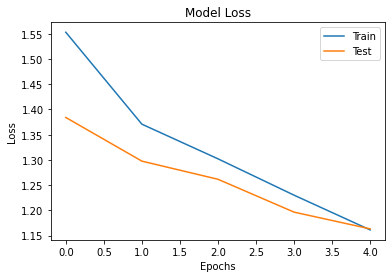

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

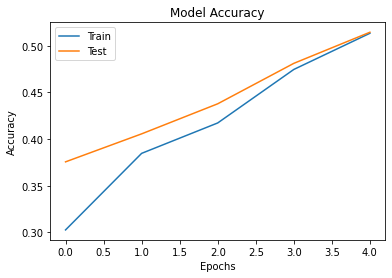

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

In [22]:
train_loss_cm, train_acc_cm = model.evaluate(train_ds, batch_size=BATCH_SIZE)
test_loss_cm, test_acc_cm = model.evaluate(val_ds, batch_size=BATCH_SIZE)
time_cm = perf_counter() - start_time
print(time_cm)

19/19 [==============================] - 9s 466ms/step - loss: 1.1638 - accuracy: 0.5139
2379.875737480994


## Transfer Learning: VGG19 Pre-trained Model

In [23]:
start_time = perf_counter()

pre_trained_model = VGG19(input_shape=(IMG_HEIGHT, IMG_WIDTH ,3), include_top=False, weights="imagenet")

#pre_trained_model.trainable = False
for layer in pre_trained_model.layers[:19]:
    layer.trainable = False

# creating the final model  
model = models.Sequential([
    pre_trained_model,
    layers.MaxPool2D((2,2) , strides = 2),
    layers.Flatten(),
    layers.Dense(len(CLASS_NAMES) , activation='softmax')
], name = 'VGG19_Model')

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "VGG19_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 3, 512)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 23045     
Total params: 20,047,429
Trainable params: 4,742,661
Non-trainable params: 15,304,768
_________________________________________________________________


In [24]:
history = model.fit(train_ds, validation_data=val_ds, validation_steps=STEP_SIZE_VALID,
                    batch_size=BATCH_SIZE, epochs=EPOCHS, steps_per_epoch=STEP_SIZE_TRAIN)

Epoch 1/5
72/72 [==============================] - 267s 4s/step - loss: 1.4672 - accuracy: 0.4436 - val_loss: 0.6479 - val_accuracy: 0.7456
Epoch 2/5
72/72 [==============================] - 266s 4s/step - loss: 0.6239 - accuracy: 0.7675 - val_loss: 0.5492 - val_accuracy: 0.8000
Epoch 3/5
72/72 [==============================] - 266s 4s/step - loss: 0.4507 - accuracy: 0.8410 - val_loss: 0.7218 - val_accuracy: 0.7578
Epoch 4/5
72/72 [==============================] - 266s 4s/step - loss: 0.4267 - accuracy: 0.8460 - val_loss: 0.5131 - val_accuracy: 0.8333
Epoch 5/5
72/72 [==============================] - 266s 4s/step - loss: 0.2998 - accuracy: 0.8909 - val_loss: 0.4877 - val_accuracy: 0.8422


### Evaluating the VGG19 CNN Model Performance

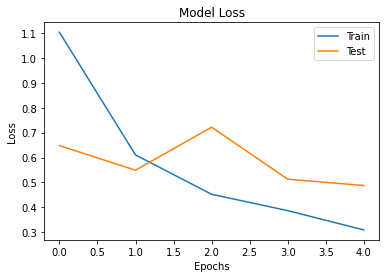

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

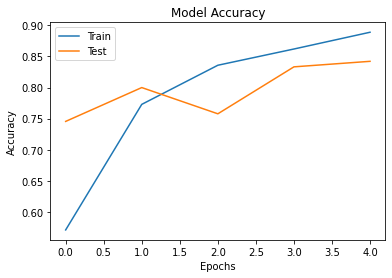

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

In [27]:
train_loss_vg, train_acc_vg = model.evaluate(train_ds, batch_size=BATCH_SIZE)
test_loss_vg, test_acc_vg = model.evaluate(val_ds, batch_size=BATCH_SIZE)
time_vg = perf_counter() - start_time
print(time_vg)

19/19 [==============================] - 49s 3s/step - loss: 0.4881 - accuracy: 0.8424
1580.1091027410002


## Transfer Learning: ResNet50 Pre-trained Model

In [28]:
start_time = perf_counter()

pre_trained_model = ResNet50(include_top=False, pooling='avg')

model = models.Sequential([
    pre_trained_model,
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(len(CLASS_NAMES), activation='softmax')
], name = 'ResNet50_Model')

model.layers[0].trainable = False

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "ResNet50_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
flatten_3 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 5125      
Total params: 25,691,013
Trainable params: 2,103,301
Non-trainable params: 23,587,712
_________________________________________________________________


In [29]:
history = model.fit(train_ds, validation_data=val_ds, validation_steps=STEP_SIZE_VALID,
                    batch_size=BATCH_SIZE, epochs=EPOCHS, steps_per_epoch=STEP_SIZE_TRAIN)

Epoch 1/5
72/72 [==============================] - 122s 2s/step - loss: 1.7742 - accuracy: 0.2670 - val_loss: 1.5368 - val_accuracy: 0.3156
Epoch 2/5
72/72 [==============================] - 118s 2s/step - loss: 1.5095 - accuracy: 0.3303 - val_loss: 1.4942 - val_accuracy: 0.3500
Epoch 3/5
72/72 [==============================] - 118s 2s/step - loss: 1.4813 - accuracy: 0.3680 - val_loss: 1.4115 - val_accuracy: 0.4322
Epoch 4/5
72/72 [==============================] - 119s 2s/step - loss: 1.4492 - accuracy: 0.3890 - val_loss: 1.4268 - val_accuracy: 0.3878
Epoch 5/5
72/72 [==============================] - 118s 2s/step - loss: 1.4183 - accuracy: 0.4153 - val_loss: 1.3781 - val_accuracy: 0.4367


### Evaluating the Resnet CNN Model Performance

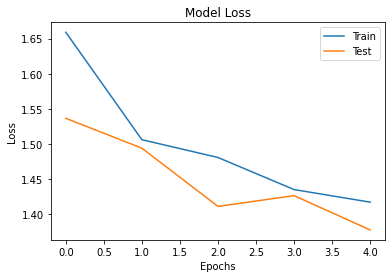

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

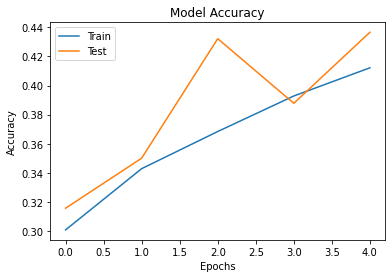

In [31]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

In [32]:
train_loss_rn, train_acc_rn = model.evaluate(train_ds, batch_size=BATCH_SIZE)
test_loss_rn, test_acc_rn = model.evaluate(val_ds, batch_size=BATCH_SIZE)
time_rn = perf_counter() - start_time
print(time_rn)

19/19 [==============================] - 21s 1s/step - loss: 1.3769 - accuracy: 0.4373
718.3059324439964


## Transfer Learning: InceptionV3 Pre-trained Model 

In [33]:
start_time = perf_counter()

pre_trained_model = InceptionV3(include_top=False, weights="imagenet", pooling='avg', classifier_activation='softmax')

model = models.Sequential([
    pre_trained_model,
    layers.Flatten(),
    layers.BatchNormalization(),
    layers.Dense(len(CLASS_NAMES), activation='softmax')
], name = 'InceptionV3_Model')

model.layers[0].trainable = False

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "InceptionV3_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
flatten_4 (Flatten)          (None, 2048)              0         
_________________________________________________________________
batch_normalization_94 (Batc (None, 2048)              8192      
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 10245     
Total params: 21,821,221
Trainable params: 14,341
Non-trainable params: 21,806,880
_________________________________________________________________


In [34]:
history = model.fit(train_ds, validation_data=val_ds, validation_steps=STEP_SIZE_VALID,
                    batch_size=BATCH_SIZE, epochs=EPOCHS, steps_per_epoch=STEP_SIZE_TRAIN)

Epoch 1/5
72/72 [==============================] - 90s 1s/step - loss: 1.0808 - accuracy: 0.6091 - val_loss: 0.6146 - val_accuracy: 0.7744
Epoch 2/5
72/72 [==============================] - 85s 1s/step - loss: 0.4575 - accuracy: 0.8340 - val_loss: 0.4960 - val_accuracy: 0.8322
Epoch 3/5
72/72 [==============================] - 87s 1s/step - loss: 0.3992 - accuracy: 0.8568 - val_loss: 0.4748 - val_accuracy: 0.8367
Epoch 4/5
72/72 [==============================] - 86s 1s/step - loss: 0.3831 - accuracy: 0.8714 - val_loss: 0.4735 - val_accuracy: 0.8511
Epoch 5/5
72/72 [==============================] - 85s 1s/step - loss: 0.3375 - accuracy: 0.8786 - val_loss: 0.4493 - val_accuracy: 0.8511


### Evaluating the InceptionV3 CNN Model Performance

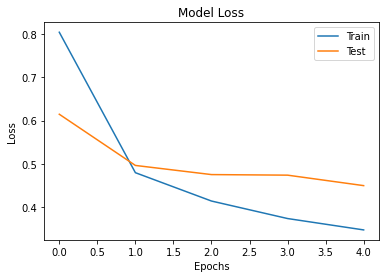

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

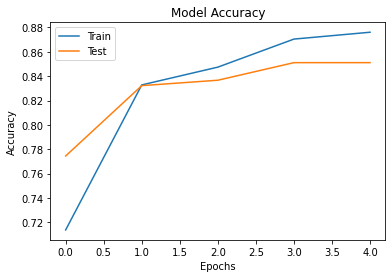

In [36]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

In [37]:
#train_loss_iv, train_acc_iv 
train_loss_iv, train_acc_iv = model.evaluate(train_ds, batch_size=BATCH_SIZE)
test_loss_iv, test_acc_iv = model.evaluate(val_ds, batch_size=BATCH_SIZE)
time_iv = perf_counter() - start_time
print(time_iv)

19/19 [==============================] - 10s 528ms/step - loss: 0.4489 - accuracy: 0.8513
524.621581845975


## Sumary  

In [39]:
print("===========================================================================")
print("===============  Compare CNN Algorithms Acurancy and Time =================")
print()
print("   Dataset size = ",SIZE_OF_DATASET,"   Train sample = ",(1-VAL_SAMPLE)*100,"%  Test sample = ",VAL_SAMPLE*100,"%")
print("   Image size: (%d,%d)   Batch size = %d         Epochs = %d        " % (IMG_HEIGHT, IMG_WIDTH, BATCH_SIZE, EPOCHS))
print()
print("Processing images:                                          time = %3.1f s" % (time_ip))
print("Simple Model:         train_acc = %1.2f    test_acc = %1.2f   time = %3.1f s" % (train_acc_sm, test_acc_sm, time_sm))
print("Complex Model:        train_acc = %1.2f    test_acc = %1.2f   time = %3.1f s" % (train_acc_cm, test_acc_cm, time_cm))
print("VGG19:                train_acc = %1.2f    test_acc = %1.2f   time = %3.1f s" % (train_acc_vg, test_acc_vg, time_vg))
print("ResNet50:             train_acc = %1.2f    test_acc = %1.2f   time = %3.1f s" % (train_acc_rn, test_acc_rn, time_rn))
print("InceptionV3:          train_acc = %1.2f    test_acc = %1.2f   time = %3.1f s" % (train_acc_iv, test_acc_iv, time_iv))
print("===========================================================================")

===============  Compare CNN Algorithms Acurancy and Time =================

   Dataset size =  4510    Train sample =  80.0 %  Test sample =  20.0 %
   Image size: (224,224)   Batch size = 50         Epochs = 5        

Processing images:                                          time = 0.7 s
Simple Model:         train_acc = 0.24    test_acc = 0.24   time = 429.9 s
Complex Model:        train_acc = 0.51    test_acc = 0.51   time = 2379.9 s
VGG19:                train_acc = 0.92    test_acc = 0.84   time = 1580.1 s
ResNet50:             train_acc = 0.40    test_acc = 0.44   time = 718.3 s
InceptionV3:          train_acc = 0.90    test_acc = 0.85   time = 524.6 s
